This script takes land use data by parcel for the municipality of Belo Horizonte's City Hall and performs an initial wrangling.

First, land uses are excessively disaggregated for the intended model. Hence, land use types will be aggregated into umbrella categories, which is also helpful to maintain compatibility throughout the time series.

Next, land uses will be inputted into a H3 hexagonal grid.

Finally, some relevant uses of the area will be superimposed in the data. That was necessary because it fixes some inconsistencies found in the original data for some of the years (in 2011, e.g., the airport was classified as a warehouse, and the landfill was marked as vacant). This is also interesting because it fixates the location of the infrastructures and marks the places where the subnormal agglomerates are.

The final sequence of steps, which is shown below, is the result of a trial and error analysis that had to devise solutions to practical issues specific to the data at hand. During this process, a number of intermediate steps are required, all of which are commented and reflected upon just before implementation.

2017 data source: http://bhmap.pbh.gov.br

Data for 2011 and 2020 have been kindly provided by PRODABEL --- https://prefeitura.pbh.gov.br/prodabel

For the years 2011 and 2020, an investigation in QGIS revealed there to be overlapping land use geometries. However, these arethe exception and most overlaps concerned areas of vacant land, while a minor number of instances were residential and retail/services. Therefore, this is not considered an important issue and the overlay operations handle this adequately.

# Preliminaries

In [1]:
import os
import pathlib
import re
import warnings

import contextily as cx
import h3
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import osmnx as ox
import pygeos as pg
import seaborn as sns

from geobr import read_municipality
from h3census.assemble import get_hexagons_with_census_data
from matplotlib.patches import Patch
from shapely.geometry import Point

%matplotlib inline
%config InlineBackend.figure_format='retina'

## Parent Folders

These should of course be adjusted to reflect the appropriate locations in your disk or wherever

In [2]:
out_folder = os.environ.get('OUT_FOLDER')
out_folder = pathlib.Path(out_folder)
out_folder = out_folder / 'A'

db_folder = os.environ.get('DB_FOLDER')
db_folder = pathlib.Path(db_folder)

## General Purpose

In [3]:
def _get_zipped_path_for_gpd(path):
    """This gets a full path for a zipped shp file and parses it
    into a structure that gpd.read_file() understands.
    """
    prefix = r'zip://'
    
    try:
        path = prefix + path.as_posix()
    except:
        path = pathlib.PureWindowsPath(path)
        path = prefix + path.as_posix()
        
        
    return path


def _get_geodata(path, is_zipped=True):
    """Takes either a full raw string path os a pathlib's pure windows
    path and uses it to return a shapefile. It also makes the necessary
    adjustments to read shapefiles compressed into a .zip file.
    """    
    if is_zipped:
        path = _get_zipped_path_for_gpd(path)
            
            
    return gpd.read_file(path)


def get_land_use_data(year):
    path = (db_folder
            / 'beaga'
            / 'tipologia_uso_ocupacao'
            / f'uso_ocup_{year}.zip')
    land_uses = _get_geodata(path)

    # A few instances are not georeferenced and, even though
    # they have an existing parcel ID, that ID is also not 
    # present at the parcel geodata provided by BH city hall.
    # This happened with 2018 data and amounted to about 0.4%,
    # which makes it seem reasoble to just drop these records.
    #
    # 2018 data will not be used anymore, but I left the code anyway.
    land_uses = land_uses.loc[land_uses
                              .geometry
                              .notnull()]
    
    # some later operations don't handle well a mix
    # of Polygons and MultyPolygons.
    land_uses = land_uses.explode()
    land_uses['area_m2'] = land_uses.area
    
    land_uses.fillna('null', inplace=True)    
    
    
    return land_uses.reset_index(drop=True)


# Land Uses in 2017

In [4]:
land_uses = get_land_use_data(2017)

land_uses.rename(columns={'TIPOLOGIA_': 'category',
                              'TIPOLOGIA0': 'use'},
                      inplace=True,)

land_uses = land_uses.reindex(columns=['category',
                                       'use',
                                       'area_m2',
                                       'geometry',])


## Land Use Regrouping

**The regrouping of land uses aims at reducing the number of categories by bringing together similar land use typologies, as the data is highly disaggregated. Not doing so would reflect into a higher number of parameters to tune, higher computational costs and into a higher number of confounding factors. Also, a high number of classes means that an even higher number of transitions happens in the model, even if some of those take place only rarely, thus it would be more difficult to distinguish meaningful patterns.**

Land uses are categorized in two ways: broad groups (relabelled above as category) and disaggregated typologies (relabelled above as use).

During this regrouping and the subsequent reclassification, I'll put the land use types uder the column 'use', while their classification into active, passive or static uses will be under 'category'.

In [5]:
land_uses.category.value_counts()

RESIDENCIAL                  217067
null                          57038
MISTO                         28128
LOTE VAGO                     28078
NAO RESIDENCIAL               25847
RESIDENCIAL+LOTE VAGO          1673
NAO RESIDENCIAL+LOTE VAGO       807
MISTO + LOTE VAGO               360
Name: category, dtype: int64

In [6]:
land_uses.use.value_counts()

casa unifamiliar                                 196979
sem informacao                                    56408
casa/sobrado                                      22249
lote vago                                         16206
edificio                                          16015
loja ou conjunto de lojas                         14650
galpao                                            12095
edificação sem tipologia especificada             11307
conjunto multifamiliar vertical                    5122
edificio residencial e comercio e/ou servicos      2555
edificio de uso comercial e/ou servicos            1683
parque                                             1241
instituicao de ensino                               529
loja em edificio/galeria                            399
conjunto multifamiliar horizontal                   376
ocupação diversificada                              303
industria                                           188
vaga residencial ou comercial                   

### Straightforward Regroupings

First of all, whenever there is combination of any active category with vacant, the whole parcel will be assumed as if belonging to he active category. Hence, a category such as "RESIDENCIAL+LOTE VAGO" will taken as if completely RESIDENCIAL. That seems reasonable enough, as it most likely only refers to parcels that have not been fully occupied. Although the unnocupied area could further develop and it would be interesting to put that into a model, there is no pratical way to figure out which portion of the parcel is vacant, exactly.

In [7]:
cat_swap = {
    'category': {'RESIDENCIAL+LOTE VAGO': 'RESIDENCIAL', 
                 'NAO RESIDENCIAL+LOTE VAGO': 'NAO RESIDENCIAL',
                 'MISTO + LOTE VAGO': 'MISTO'}
}
land_uses = land_uses.replace(cat_swap)

Next, come the uses that can be relabelled in a more straightforward fashion based on their use.

- Most instances are straightforward, such as 'casa unifamiliar', for example, which clearly is residential; or such as 'edificio de uso comercial e/ou servicos' which is obviously retail/services.

- There were cases in which discordant classifications were residual. Hence, the residuals have been put together along with the majority class. For example, there are 6 mixed use parcels of 'edificio' amidst a sea of 16009 residential parcels.

- Mixed uses presented a difficulty as well because the classical model deals with discrete classifications only. There are models that allow for some fuzzy classification, which means that a cell can go from fully residential to completely commercial, while being able to assume any percentual balance in between those extremes. Unfortunatelly, to the best of my knowledge, such models seem still incipient and displaying some perks that I don't think are for me to solve (at least not now). Hence, I chose to create a 'mixed' category and leave it at that. After some future experimentations, I might choose to place it either under retail/services or under residential.

- All parcels containing any kind of (a) club or public goods, and of (b) public facilities, amenities or infrastructures have been considered static and are all labeled as either:
    - amenities,
    - infrastructure, or
    - public services.

In [8]:
regrouping = {
    'active': {
        'residential': ['casa unifamiliar',
                        'edificio', 
                        'conjunto multifamiliar vertical',
                        'conjunto multifamiliar horizontal',],
        
        'retail/services': ['loja ou conjunto de lojas',
                            'edificio de uso comercial e/ou servicos',
                            'loja em edificio/galeria',
                            'shopping center',
                            'galeria/mini shopping de bairro',
                            'apart hotel',],
        # TO DO: settle approach towards mixed uses
        'mixed': ['casa/sobrado',
                  'edificio residencial e comercio e/ou servicos',]
                },

     'passive': { 
         'vacant': ['lote vago',]
                 },

     'static': {
         'industry': ['industria',],
         
         'public services': ['instituicao de ensino',
                             'equipamento de saude',],
         
         'infrastructure': ['estacao de transporte coletivo',
                            'aeroporto',
                            'aterro sanitario',],
         
         'amenities': ['instituicao religiosa',
                       'cemiterio', # bit weird to put it here, but I couldn't find anywhere else
                       'parque',
                       'clubes esportivos e sociais',
                       'estadio/ginasio',],
               }
}

In [9]:
def regroup_land_uses(gdf, dictionary):
    for new_cat, use_corresp in dictionary.items():
        for new_use, old_uses in use_corresp.items():
            mask = gdf.use.isin(old_uses)
            gdf.loc[mask, 'category'] = new_cat
            
            replacements = {
                'use': {old_use: new_use
                        for old_use
                        in old_uses} 
            }
            
            gdf.update(gdf.replace(replacements))
            

In [10]:
regroup_land_uses(land_uses,
                  regrouping,)

### Creative Regroupings

**The following parcels required a more in-depth analysis and some ingenuity to be regrouped in way that most likely resembles reality. These involved, for example, inspection of aerial or satellite photographs. The following goes through some specifics:**

- Even though 'edificação sem tipologia especificada' (buildings without specified typology) is within LOTE VAGO (vacant parcel), a minute inspection showed that doing so would result in errors: although there are vacant regions indeeed, there are a number of parcels that coincide with favela ocupied areas. To put it another way, I found that there are a majority of plots whose areas are abot the same as the usual urban block, and a minority of extensive parcels in peripheral areas, which seem to overlap green areas in aerial imagery. Therefore, the first classification step involved distinguishing them both based on area. Next, there is the matter of which urban land use is present in the smalller parcels. These were assumed to be residential. In short:

    - Parcels are first distinguished by area: parcels whose area is lager than Q3 + 1.5IQ (where Q3 is the third quartile and IQ is the interquartile range) of 'edificação sem tipologia especificada' are taken as vacant, while the remaining ones are assumed residential.
    - The residential use was assumed for the smaller ones because for any given lot in Belo Horizonte, the use that occupies it, with the highest probability is residential. Also, in the brazilian context, there is plenty of illegal land ocupation due to favelas and whatnot. Lastly, I assumed it is harder for commercial activity to function without registry in the tax records.
    
- 'sem informacao' will be classified just as 'edificação sem tipologia especificada'.
    
 - There are two land use categories that are unclear in of themselves ('ocupação diversificada', 'vaga residencial ou comercial') these have been classified with the use of the broad category they belong to, as either residential, mixed or retail/services.

- 'galpao' (warehouses) seemed more obviously related to the industrial sector. But according to the methodological notes, the warehouses that comport industries had already been relabelled as industry. Additionally, their spatial distribution, scattered across the inner city further supports the reasoning that they are not industry, strictly speaking. Hence, for the time being, that use was placed under either retail/services or mixed, and the choice for one or the other was made based on the broad category that parcel belongs to.


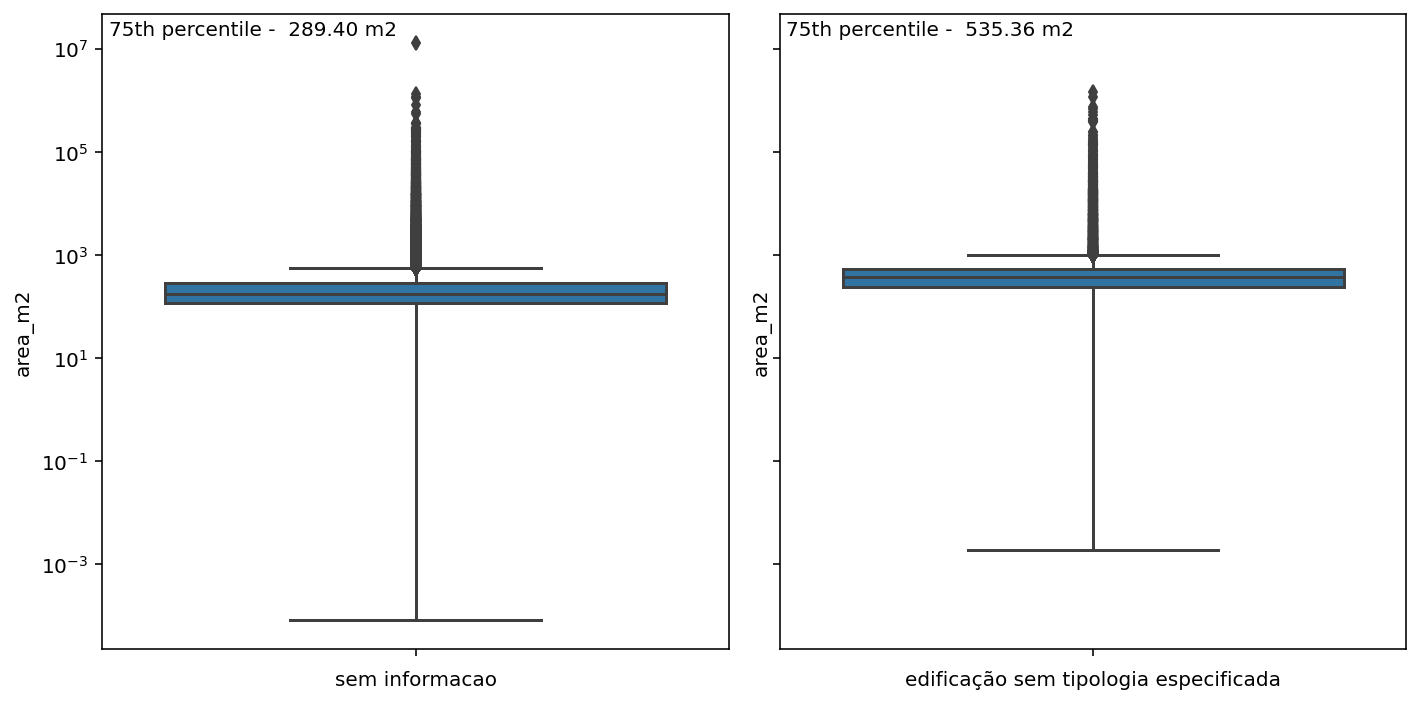

In [11]:
def boxplot_parcel_areas(data, uses_to_plot):
    no_plots = len(uses_to_plot)
    x_length = 5 * no_plots
    f, axes = plt.subplots(ncols=no_plots,
                           figsize=(x_length, 5),
                           sharey=True)
    try:
        axes = axes.flatten()
    except:
        axes = [axes]
    
    for i, use in enumerate(uses_to_plot):
        view = data.loc[(data.use==use)]
        sns.boxplot(data=view, y='area_m2', ax=axes[i])
        axes[i].set_xlabel(use)
        
        percentile_75 = view.area.quantile(.75)
        axes[i].annotate(f'75th percentile - {percentile_75: .2f} m2',
                         xy=(0.01, 0.99),
                         xycoords=axes[i].transAxes,
                         verticalalignment='top',
                         horizontalalignment='left')
        axes[i].set_yscale('log')
        
        
    f.tight_layout()
        
        
boxplot_parcel_areas(land_uses,
                     uses_to_plot=['sem informacao',
                                   'edificação sem tipologia especificada'])

In [12]:
def area_based_regrouping(data, uses):
    for use in uses:
        mask = data.use==use
        view = data.loc[mask]
        
        q_25 = view.area.quantile(.25)
        q_75 = view.area.quantile(.75)
        area_threshold = q_75 + 1.5 * (q_75 - q_25)
        
        residential_mask = mask & (data.area<=area_threshold)
        data.loc[residential_mask, 'category'] = 'active'
        data.loc[residential_mask, 'use'] = 'residential'
        
        vacant_mask = mask & (data.area>area_threshold)
        data.loc[vacant_mask, 'category'] = 'passive'
        data.loc[vacant_mask, 'use'] = 'vacant'
        

In [13]:
area_based_regrouping(land_uses,
                      uses= ['sem informacao',
                             'edificação sem tipologia especificada'])

In [14]:
land_uses.loc[land_uses.category=='RESIDENCIAL'].use.value_counts()

ocupação diversificada           126
vaga residencial ou comercial     57
Name: use, dtype: int64

In [15]:
land_uses.loc[land_uses.category=='NAO RESIDENCIAL'].use.value_counts()

galpao                           8722
vaga residencial ou comercial     119
ocupação diversificada             64
Name: use, dtype: int64

In [16]:
land_uses.loc[land_uses.category == 'MISTO'].use.value_counts()

galpao                           3373
ocupação diversificada            113
vaga residencial ou comercial       1
Name: use, dtype: int64

In [17]:
land_uses.loc[land_uses.category=='RESIDENCIAL', 'use'] = 'residential'
land_uses.loc[land_uses.category=='NAO RESIDENCIAL', 'use'] = 'retail/services'
land_uses.loc[land_uses.category=='MISTO', 'use'] = 'mixed'

replacements = {
    'category': {'RESIDENCIAL': 'active',
                 'NAO RESIDENCIAL': 'active',
                 'MISTO': 'active',}
}
land_uses = land_uses.replace(replacements)   

In [18]:
lu_2017 = land_uses.copy()

# Land Uses in 2011

In [19]:
land_uses = get_land_use_data(2011)

land_uses.rename(columns={'descr_uso': 'category',
                          'descr_ocup': 'use'},
                 inplace=True,)

land_uses = land_uses.reindex(columns=['category',
                                       'use',
                                       'area_m2',
                                       'geometry',])

## Land Use Regrouping

The steps taken here are nearly the same as the ones taken in 2017. The following exceptions are worth comment, though:

- Vacant parcels are not mixed with any other category such as in 2017 - e.g., RESIDENCIAL+LOTE VAGO (residential + vacant) does not exist.

- All instances of 'galpão' (warehouse) are under 'não residencial' (non residential) use, while in 2017 there was a considerable portion within mixed use.

- In 2011 there is the land use ZEIS-1, which corresponds to special Zones of Social Interest. These are an instrument of urban and housing policy, created in 1980, whose goal is to improve the infrastructure and secure land tenure to residents of areas of spontaneous urbanization (roughly said, favelas, which are mostly residential)

- 'indeterminado', 'nulo', and 'edificações em LV' seem to have the same behavior as the one verified for 'sem informacao' and 'edificação sem tipologia especificada' in 2017.

In [20]:
regrouping = {
    'active': {
        'residential': ['casa unifamiliar',
                        'edifício', 
                        'conjunto multifamiliar vertical',
                        'conjunto multifamiliar horizontal',
                        'ZEIS-1',],
        
        'retail/services': ['loja ou conjunto de lojas',
                            'edifício de uso comercial e/ou de serviços',
                            'loja em edifício / galeria',
                            'shopping',
                            'galeria / mini-shopping de bairro',
                            'apart hotel',
                            'galpão',],
        # TO DO: settle approach towards mixed uses
        'mixed': ['casa / sobrado',
                  'edifício residencial e comércio e/ou serviços',]
                },

     'passive': { 
         'vacant': ['lote vago',]
                 },

     'static': {
         'industry': ['indústria',],
         
         'public services': ['instituição de ensino',
                             'equipamento de saúde',],
         
         'infrastructure': ['estação de transporte coletivo',
                            'aeroporto',
                            'aterro sanitario',],
         
         'amenities': ['instituição religiosa',
                       'cemitério', # bit weird to put it here, but I couldn't find anywhere else
                       'parques',
                       'clubes esportivos e sociais',
                       'estadio/ginasio',],
               }
}

In [21]:
regroup_land_uses(land_uses,
                  regrouping,)

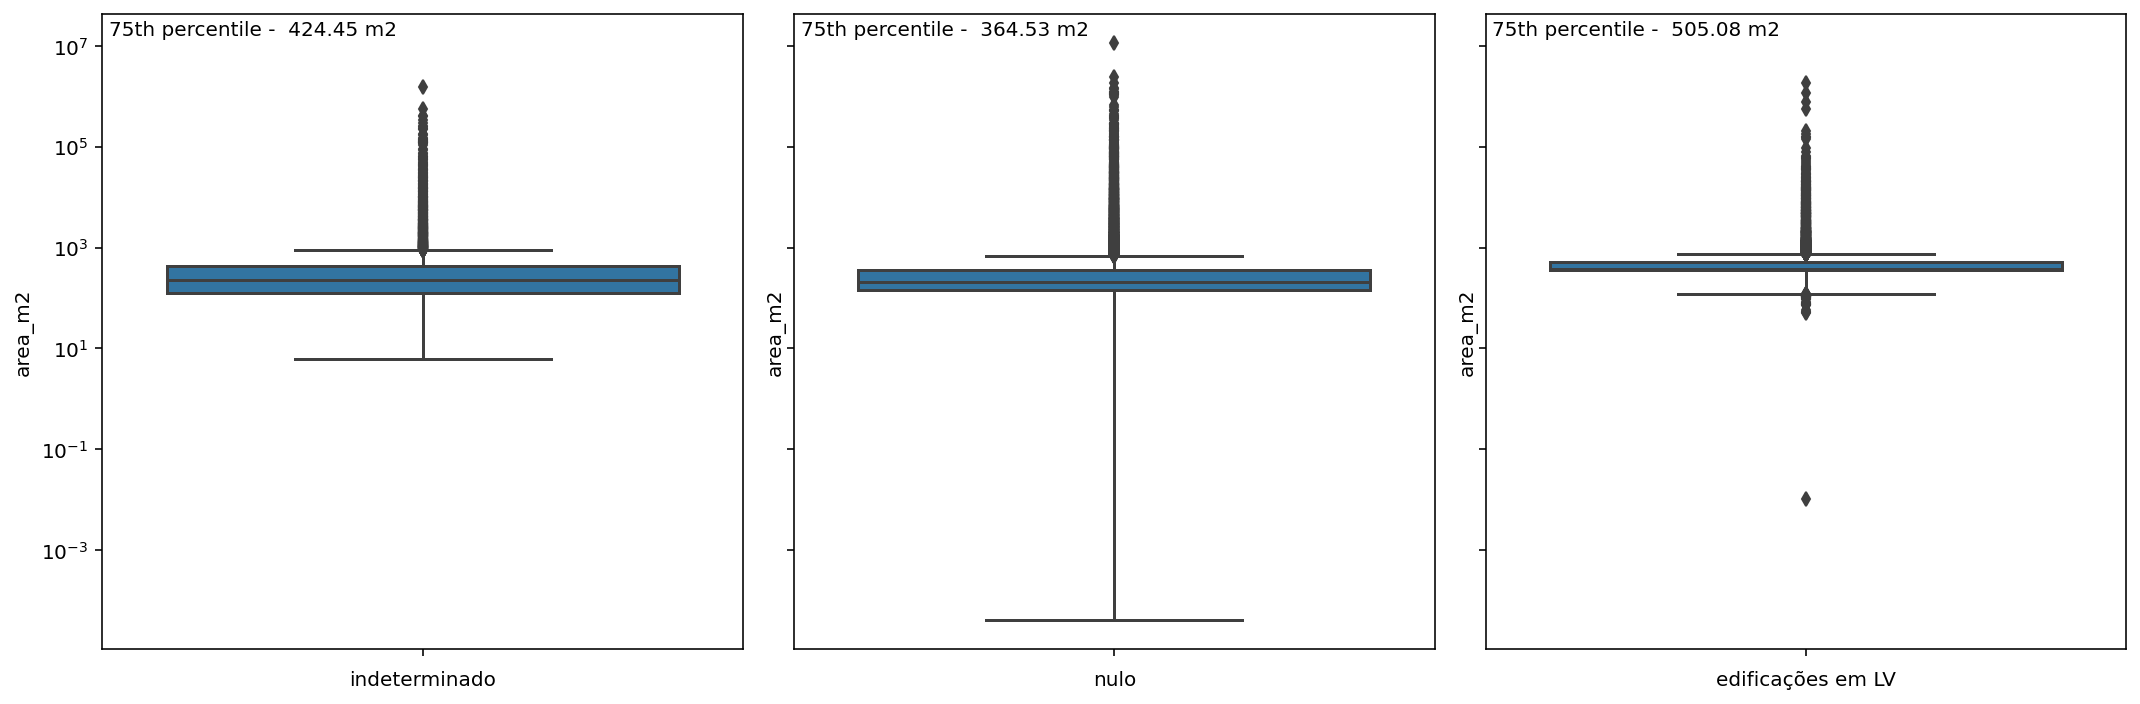

In [22]:
boxplot_parcel_areas(land_uses,
                     uses_to_plot=['indeterminado',
                                   'nulo',
                                   'edificações em LV',])

In [23]:
area_based_regrouping(land_uses,
                      uses=['indeterminado',
                            'nulo',
                            'edificações em LV',])

In [24]:
lu_2011 = land_uses.copy()

# Land Use Maps for 2020

In [25]:
land_uses = get_land_use_data(2020)


land_uses = land_uses.rename(columns={'uso_do_s_1': 'category',
                                      'uso_ativ_1': 'use',
                                      'agreg_ativ': 'activities'})

land_uses = land_uses.reindex(columns=['category',
                                       'use',
                                       'activities',
                                       'area_m2',
                                       'geometry'])


In [26]:
# Land use categories and types are between curly brackets
# by whatever reason...
regex = r'(\{?)(.+\w)(\})?'

for each in ['category', 'use']:
    land_uses[each] = land_uses[each].str.extract(regex)[1]

In [27]:
regrouping = {
    'active': {
        'residential': ['CASA/SOBRADO RESIDENCIAL',
                        'EDIFICIO RESIDENCIAL',],
        
        'retail/services': ['EDIFICIO NAO RESIDENCIAL',
                            'CASA DE SHOW',
                            'INSTITUICAO FINANCEIRA',
                            'HOTEIS/MOTEIS E SIMILARES',
                            'ESTACIONAMENTO',
                            'CASA/SOBRADO NAO RESIDENCIAL',
                            'SUPERMERCADO/HIPERMERCADO',
                            'SHOPPING CENTER',
                            'GALPAO COMERCIAL',],
        # TO DO: settle approach towards mixed uses
        'mixed': ['CASA/SOBRADO DE USO MISTO',
                  'EDIFICIO DE USO MISTO',],
                },

     'passive': { 
         'vacant': ['LOTE VAGO',]
                 },

     'static': {
         'industry': ['GALPAO INDUSTRIAL',],
         
         'public services': ['INSTITUICAO DE ENSINO',
                             'HOSPITAL/SERVICO DE SAUDE',
                             'SERVICOS PUBLICOS',],
         
         'infrastructure' : ['TERMINAL RODOVIARIO/FERROVIARIO',
                             'AEROPORTO',
                             'CEMITERIO',
                             'ATERRO SANITARIO',],
         
         'amenities' : ['CLUBE ESPORTIVO/SOCIAL',
                        'CENTRO DE CONVENCOES/EXPOSICOES',
                        'INSTITUICAO CULTURAL',
                        'ESTADIO/GINASIO',
                        'INSTITUICAO RELIGIOSA',
                        'PARQUE',],
               }
}

In [28]:
regroup_land_uses(land_uses,
                  regrouping,)

Using the same classification scheme for for parcels labeled as SEM INFORMACAO (no information), as it was done in 2011 and 2017, results in a considerable number of parcels in the urban fabric would be classified as vacant, transitioning from residential or from retail/services, for example. This could suggest that the city shrank to some extent, which is a priori plausible, given the severe economic crisis Brazil has been facing in the last few years. 

But an ad hoc inspection on Google maps of some the suposedly vacant places shows them to be actually occupied. Indeed, a closer look into the 2020 land use data shows that some of parcels labeled as 'no information' are actually given a broad classification in the column 'category'. Furthermore, the attribute 'activities' contains, for a non negligible number of parcels, a list of economic activities contained therein.

Consequently, the area based classification procedure will only be applied once we have exhausted the sources of information above.

First, whenever the broad category is RESIDENCIAL or MISTO, land uses will be turned to residential or mixed, respectively

In [29]:
land_uses.loc[land_uses.category=='RESIDENCIAL', 'use'] = 'residential'
land_uses.loc[land_uses.category=='MISTO', 'use'] = 'mixed'

land_uses.loc[land_uses.category=='RESIDENCIAL', 'category'] = 'active'
land_uses.loc[land_uses.category=='MISTO', 'category'] = 'active'

Next, the classification will be based in the activities contained within the parcel, when that information is available.

Activities are labeled according to a three letter code. Any given parcel may contain more than one activity, and can contain the same activity more than once. In effect, for each activity there is a three letter code. We are specifically interested in the following.

- **COM**: commerce
- **CSH**: nightclubs and the like
- **EST**: parking lots
- **HMS**: hotels, motels, lodgings etc.
- **IFI**: finantial institutions
- **IND**: industry
- **OSE**: other services
- **PCO**: gas station
- **SHI**: grocery stores

Whenever any one of these is within a parcel, it will be assumed to be the dominant use.

Finally, it should be underscored that IND will be treated as retail/services because I assume that large industries, have already been labeled as such. Hence, IND should refer to craftsmanship and manual labor developed in small facilities (even households).

In [30]:
def classify_with_activities(row):
    activity_list = ['COM', 'CSH', 'EST',
                     'HSM', 'IFI', 'IND',
                     'OSE', 'PCO', 'SHI']
    
    if row.use == 'SEM INFORMACAO':
        regex = r'(\w{3})'
        matches = re.findall(regex, row.activities)

        unique = np.unique(matches)

        if np.isin(unique, activity_list).any():
            row.category = 'active'
            row.use = 'retail/services'
        
        
    return row


In [31]:
land_uses = land_uses.apply(lambda x: classify_with_activities(x),
                            axis=1)

In [32]:
land_uses.loc[land_uses.use == 'SEM INFORMACAO', 'activities'].value_counts()

null                                                                     47828
{IRE,IRE,IRE,IRE}                                                           16
{SSA,SSA,SSA}                                                               10
{SSA,SSA}                                                                    6
{SSA,SSA,SSA,SSA}                                                            4
{SSA,SSA,SSA,SSA,SSA}                                                        3
{SSA,SSA,SSA,SSA,SSA,SSA,SSA}                                                2
{SSA,SSA,SSA,SSA,SSA,SSA,SSA,SSA}                                            2
{SSA,SSA,SSA,SSA,SSA,SSA}                                                    2
{AUR}                                                                        2
{SSA,SSA,SSA,SSA,SSA,SSA,SSA,SSA,SSA,SSA,SSA}                                1
{SSA,SSA,SSA,SSA,SSA,SSA,SSA,SSA,SSA}                                        1
{SSA,SSA,SSA,SSA,SSA,SSA,SSA,SSA,SSA,SSA,SSA,SSA,SSA

What remains are residual parcels which will be treated along with that which is by far the largest remaining category: null. These latter parcels cannot be classified without the aid of auxilliary information. Hence, all that is left is to classify them based on their area.

Once land uses are inputted within the hexagons, there is a recategorization process that might find what are their specficic uses.

In [33]:
boxplot_parcel_areas(land_uses,
                     uses_to_plot=['SEM INFORMACAO',])

In [34]:
area_based_regrouping(land_uses,
                      uses=['SEM INFORMACAO',])

In [35]:
lu_2020 = land_uses.drop(columns='activities')

# Study Area Tesselation

The study area shall be restricted to the municipality of Belo Horizonte. That seemed the most reasonable approach, since there's not near enough data on the neighboring municipalities. That is a clear limitation of the model, since Belo Horizonte is the core of a conurbated metropolitan area. Nevertheless, as the object of the thesis is not sprawl, but rather the transformations of the intra-urban space, that may not be that critical, after all. In fact, Stanilov & Batty (2011) showed how a cellular automata might be suitable for modeling a single portion of a city.

In that light, I will fill the municipalities administrative borders with a hexagonal grid of Uber's H3 cells.

## Retrieving H3 Hexagons

The resolution of the hexagons is defined in a way that its area is close to the median area of a land parcel in Belo Horizonte.

In [36]:
def get_hexagon_edge_length(land_uses):
    """Computes the edge of an hexagon with the same area as that
    of the median parcel. It considers only active uses because
    both passive and static include may include quite large areas.
    
    Requires projected CRS.
    """
    view = land_uses.loc[land_uses.category=='active']
    median_area = np.median(view.area_m2)
    edge_length = np.sqrt(median_area * 2 / (3 * np.sqrt(3)))
    
    print(f'Hex edge should be of approximately {edge_length:.2f} meters') 

# land_uses contains 2020 data, now,
# but median parcel sizes should not
# change much through the years
get_hexagon_edge_length(land_uses)

Hex edge should be of approximately 11.76 meters


That leaves either H3 resolution 11 (edge length of approx. 25m) or resolution 12 (~9.5m) — _refer to https://h3geo.org/docs/core-library/restable/ for H3 resolutions_

I'll adopt ***Resolution 12*** for the time being, but might go up to resolution 11 if I run into processing time issues.

In [37]:
state = 31 # MG ibgeID as int
ibgeID = '3106200' # Belo Horizonte ibgeID as str
                   # TO DO: allow ibgeID as int as well
hexagon_size = 9

path_to_census = (db_folder
                  / 'census'
                  / '2010 Universo'
                  / '2010_aggregates_by_enumeration_area.csv')

usecols = {
    'v002': 'pop',
    # Average income of all those who are 10 years
    # or older and earn wages of some sort
    'v011': 'income',
         }

# TO DO: allow for 'area_weighted_vars' and
# 'pop_weighted_vars' not to be lists
hexagons = get_hexagons_with_census_data(state,
                                         ibgeID,
                                         hexagon_size,
                                         usecols,
                                         area_weighted_vars=['pop'],
                                         query_data=False,
                                         save_query=False,
                                         path=path_to_census,
                                         pop_col='pop',
                                         pop_weighted_vars=['income'],
                                         output_epsg=31983,)

Sanity check:
 2891 H3 labels, with resolution 9,  after dropping 0 duplicates


## Land Use Imputation

The above is based on answers to this issue: https://github.com/geopandas/geopandas/issues/1724#issuecomment-740062943

In [38]:
def _get_uses_in_hex(land_uses, hexagons, apperture,
                     hex_idx=True, hex_col=None):
    if hex_idx:
        hex_labels = f'hex_{apperture}'
        hexagons.index.name = hex_labels
        hexes = hexagons.reset_index()
    else:
        hex_labels = hex_col
    
    overlay = gpd.overlay(land_uses,
                          hexes)
    overlay['intersect_area'] = overlay.area
    
    
    return (overlay.groupby([hex_labels, 'category', 'use'],
                            as_index=False)
                   .intersect_area
                   .sum())


def _find_dominant_use(group, hex_area):    
    #if hex_area/3 > group.intersect_area.sum():
    #    category, use = np.nan, np.nan
    #else:
    #    data = group.set_index(['category', 'use'])
    #    category, use = data.intersect_area.idxmax()
    
    data = group.set_index(['category', 'use'])
    category, use = data.intersect_area.idxmax()
        
    
    return pd.Series(data=[category, use],
                     index=['category', 'use'])


def input_uses(land_uses, hexagons, apperture,
               hex_idx=True, hex_col=None):
    """Uses overlay operations to input uses into cells.
    Cell will have the use that occupies most of its area.
    If land use polygons do not cover at least half of the
    cell's area, said cell will have nan in its land use.
    
    Assumes that both land uses and hexagons are
    in the same projected CRS.
    """
    
    uses_by_hex = _get_uses_in_hex(land_uses,
                                   hexagons,
                                   apperture,
                                   hex_idx,
                                   hex_col)
    
    hex_area = h3.hex_area(apperture, unit='m^2')
    hex_col = f'hex_{apperture}'
    dom_use = (uses_by_hex.groupby(hex_col)
                          .apply(_find_dominant_use, hex_area)
              )
    
    
    return (hexagons.merge(dom_use,
                           left_index=True,
                           right_on=hex_col,
                           how='left',)
                    .set_index(hex_col))

In [39]:
hex_2011 = input_uses(lu_2011,
                      hexagons,
                      hexagon_size)

In [40]:
hex_2017 = input_uses(lu_2017,
                      hexagons,
                      hexagon_size)

In [41]:
hex_2020 = input_uses(lu_2020,
                      hexagons,
                      hexagon_size)

# Category Revision

This section concerns some more specific land use (re)classifications that have to be made manually.
- First, whatever hexagons intersect with the road network will be labeled as infrastructure and are then fixed as a static land use. The superimpositon of the land use data shows that the empty spaces between parcels remain mostly constant thrpughout the years, which implies that no major changes happened to the street grid layout. Hence, I'll use the current street topology as retrieved from OpenStreetMaps by osmnx.
- Second, some major local landmarks are enforced. That is done especially because of the 2011 data, which missclassified some old and established local landmarks or infrastructures. For example, the local airport was marked as a warehouse, and both some parks and the landfill were marked as vacant. Another example is that of Lake Pampulha, which is understandably not represented by polygons of any kind - somewhere that is not land could not be represented by a land use polygon after all. Nevertheless, I chose to retain that region in the hexgonal grid of the municipality, which are then maked as amenity.
- Third, there are parcels that mostly coincide with the footprints of the subnormal agglomerates in the municipality - see note below. Those are to be labeled subnormal. It remains to be seen whether its worth keeping them separated.

***It should be noted that some vacant plots are preservation areas and cannot be occupied during simulation. Such constrainsts are to be enforced when zoning restrictions are imposed in the model.***


***Note:***

A subnormal agglomerate is a form of irregular occupation of land – either public or private - owned by a third party, for housing purposes in urban areas, usually characterized by an irregular urban pattern, with scarce essential public services and located in areas not proper or allowed for housing use.  In Brazil, those irregular settlements are known by the names of favelas, invaded areas, slums in deep valleys, slums in low-lands, communities, villages, slums in backwaters, irregular lots, shacks and stilt houses

## Auxilliary Datasets

In [42]:
# BH city hall uses the term favelas for the subnormal agglomerates
path_to_favelas = (db_folder
                   / 'beaga'
                   / 'footprints'
                   / 'vila_favela.zip')
favelas = _get_geodata(path_to_favelas)

favela data:
   - BH Maps: http://bhmap.pbh.gov.br
   
It should be noted that the temporality of the favela geodata is not clear. The metadata (https://bit.ly/BH_favela_metadata) suggests that the file is updated whenever the public administration deems necessary, which implies that the location of the subnormal communities should be up to date with the time with which this script was written (2021). Thus, on first thought, it follows that the data should reflect, with reasonable accuracy, the location of such communities for the 2017, 2018 and 2020 maps, as there's no evidence to suppose that a major favela growth happened in the last couple of years.

A later analysis reinforced this reasoning because the footprint of the favelas remarkably fits some data voids in the land use data for 2011 as well. Notheless, the data will be joined with IBGE's data as it fills some minor gaps present in BH's data.

In [43]:
path_to_subnormal = (db_folder
                     / 'census'
                     / '2010_subnormal_agglomerates'
                     / 'SetoresXAreaDivAGSN_shp.zip') 
subnormal_agg = _get_geodata(path_to_subnormal)

# IBGE data provides all census tracts of Brazil and
# specifies which are subnormal, so that we need to
# slice the dataset.
#
# First we select only census tracts of BH city. To do
# that end we take advantage of the fact the tract IDs 
# contain the city ID they belong to.
#
# Second, we use the appropriate column to select the
# subnormal places.
subnormal_agg = subnormal_agg.loc[subnormal_agg
                                  .CD_GEOCODI
                                  .str
                                  .match('3106200')] # ibgeID for BH

subnormal_agg = subnormal_agg.loc[subnormal_agg
                                  .Subnormal == 'Sim']

# IBGE data comes in a geographic coordinate system
# that needd to be projected to the same CRS as
# Belo Horizonte's data
subnormal_agg.to_crs(epsg=31983, inplace=True)

data on subnormal agglomerates:

- IBGE: ftp://geoftp.ibge.gov.br/recortes_para_fins_estatisticos/malha_de_aglomerados_subnormais/censo_2010/areas_de_divulgacao_da_amostra/

In [44]:
def _get_slums_footprint(favelas, subnormal_agg):
    slums = gpd.overlay(favelas,
                        subnormal_agg,
                        how='union',)
    
    
    return (slums.reindex(columns=['geometry'])
                 .explode()
                 .reset_index(drop=True))


In [45]:
def _polys_from_osm(osm_tags):
    # osmnx code presents the deprecation explained in the link below.
    # It should not impact performance in any way. I filtered it though
    # merely because I find there are too many annoying warnings
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore',
                                category=DeprecationWarning)
        gdf = ox.geometries_from_place('Belo Horizonte, MG, Brazil',
                                        tags=osm_tags,)
    
    mask = gdf.type.isin(['Polygon', 'MultiPolygon'])
    
    
    return (gdf.loc[mask]
               .reindex(columns=['geometry'])
               .reset_index()
               .to_crs(epsg=31983)) #TO DO: unhardcode this?


def _get_greenery():
    osm_tags = {'name': 'Parque das Mangabeiras',

                'leisure': [
                           'park',
                           'nature_reserve',
                           ],

                'boundary': [
                            'national_park',
                            'protected_area',
                            ],
                
                'natural': [
                           'wood', 'tree_row', 'tree','scrub',
                           'heath', 'moor','grassland', 'fell',
                           'bare_rock', 'scree', 'shingle', 'sand', 'mud',
                           ]
               }
        
    
    return _polys_from_osm(osm_tags)
    

def _get_amenities():    
    osm_tags = {'tourism': 'zoo',
                
                # This does not seem necessary, really...
                #'name': 'Lagoa da Pampulha',

                'leisure': [
                           'stadium',
                           'sports_centre',
                           ],
               }
    
    
    return _polys_from_osm(osm_tags)
    
    
def _get_infrastructures():
    osm_tags = {'name': [
                        'Aeroporto',
                        'ETE Onça',
                        ],
            
                'landuse': 'landfill'}
    
    
    return _polys_from_osm(osm_tags)
    

def _reclassify_landmarks(hexes, gdf):
    
    landmarks = {('passive', 'vacant'): _get_greenery(),
                 ('static', 'amenities'): _get_amenities(),
                 ('static', 'infrastructure'): _get_infrastructures()}
    
    for keys, polys in landmarks.items():
        join = gpd.sjoin(gdf,
                         polys,
                         op='within',
                         how='inner',)
        
        hexes.loc[hexes.index.isin(join.index), 'category'] = keys[0]
        hexes.loc[hexes.index.isin(join.index), 'use'] = keys[1]
            

In [46]:
def _reclassify_subnormal(hexes, gdf, slums):
    
    join = gpd.sjoin(gdf,
                     slums,
                     op='within',
                     how='inner')
    
    # The main goal is to find where subnormal residences are, by
    # recategorizing (a) residential uses, (b) vacant land or, mostly,
    # (c) cells with otherwise no data on them. If the uses below
    # are not fixed, I'd loose the (possible) richness in activity
    # diversity within the slums.
    consolidated_uses = ['retail/services', 'mixed',
                         'industry', 'infrastructure',
                         'amenities', 'public services',]
    
    mask = (
        ~hexes.use.isin(consolidated_uses) & hexes.index.isin(join.index)
    )
    hexes.loc[mask, 'category'] = 'active'
    hexes.loc[mask, 'use'] = 'subnormal'
    

## Reclassifying

***Note***: reassining to infrastructure all cells that touch infrastructure does not work for larger cells sizes. That happens because if greater than a given size, the hexagon will be larger than city blocks and will thus intersect with a street somewhere. Hence, if the problem is to be scalable, this must be handled.

In [47]:
def reclassify_land_uses(hexes, favelas, subnormal_agg):
    hexes['center'] = [Point(x, y)
                       for x, y
                       in zip(hexes.x_epsg31983, hexes.y_epsg31983)]
    gdf = hexes.set_geometry('center')
    hexes.drop(columns='center', inplace=True)
    
    _reclassify_landmarks(hexes, gdf)
    
    slums = _get_slums_footprint(favelas,
                                 subnormal_agg)
    
    _reclassify_subnormal(hexes, gdf, slums)


In [48]:
for each in [hex_2011, hex_2017, hex_2020]:
    reclassify_land_uses(each,
                         favelas,
                         subnormal_agg)

In [49]:
path_to_hexes = (out_folder
                 / f'BH_hex_{hexagon_size}_with_land_uses.gpkg')

hex_2011.to_file(path_to_hexes,
                 layer='2011',
                 driver='GPKG',)

hex_2017.to_file(path_to_hexes,
                 layer='2017',
                 driver='GPKG',)

hex_2020.to_file(path_to_hexes,
                 layer='2020',
                 driver='GPKG',)

# Plotting

In [50]:
def _subplot(parcels, attribute, palette, ax):
    legend_elements = []
    for cat, group in parcels.groupby(attribute):
        color = palette[cat]

        group.plot(ax=ax,
                   color=color,)

        patch_element = Patch(facecolor=color,
                              edgecolor=color,
                              label=cat,)

        legend_elements.append(patch_element)

    ax.legend(handles=legend_elements,
              bbox_to_anchor=(1, 0.01),
              loc='lower right',
              prop={'size': 3},)
    
    ax.axis('off')
    
    # Web map tiles are typically provided in Web Mercator
    # (EPSG 3857) and that's contextily default. Hence, CRS
    # needs to be adjusted to match geodata.
    cx.add_basemap(ax,
                   crs=parcels.crs.to_string(),
                   source=cx.providers.CartoDB.PositronNoLabels,
                   attribution_size=2,)
    
    
def plot_land_uses(hexagons, year, category_palette, use_palette):
    f, axes = plt.subplots(ncols=2, dpi=300, figsize=(5, 8))
    ax1,ax2 = axes
    
    _subplot(hexagons,
             'category',
             category_palette,
             ax1,)

    _subplot(hexagons,
             'use',
             use_palette,
             ax2,)
    
    f.tight_layout()

    plt.savefig(out_folder / f'land_use_map_{year}.png',
                dpi=300,)
    plt.show()
    
    

In [51]:
category_palette = {'active': '#C97064',
                    'static': '#39487F',
                    'passive': '#527048',}

use_palette = {'residential': '#FECEF1',
               'subnormal': '#B05F66',
               'retail/services': '#3B727C',
               'mixed': '#60E1E0',
               'vacant': '#82A775',
               'industry': '#291A10',
               'infrastructure': '#FFFBDB',
               'public services': '#A85118',
               'amenities': '#7D573C',}

## Map for 2011

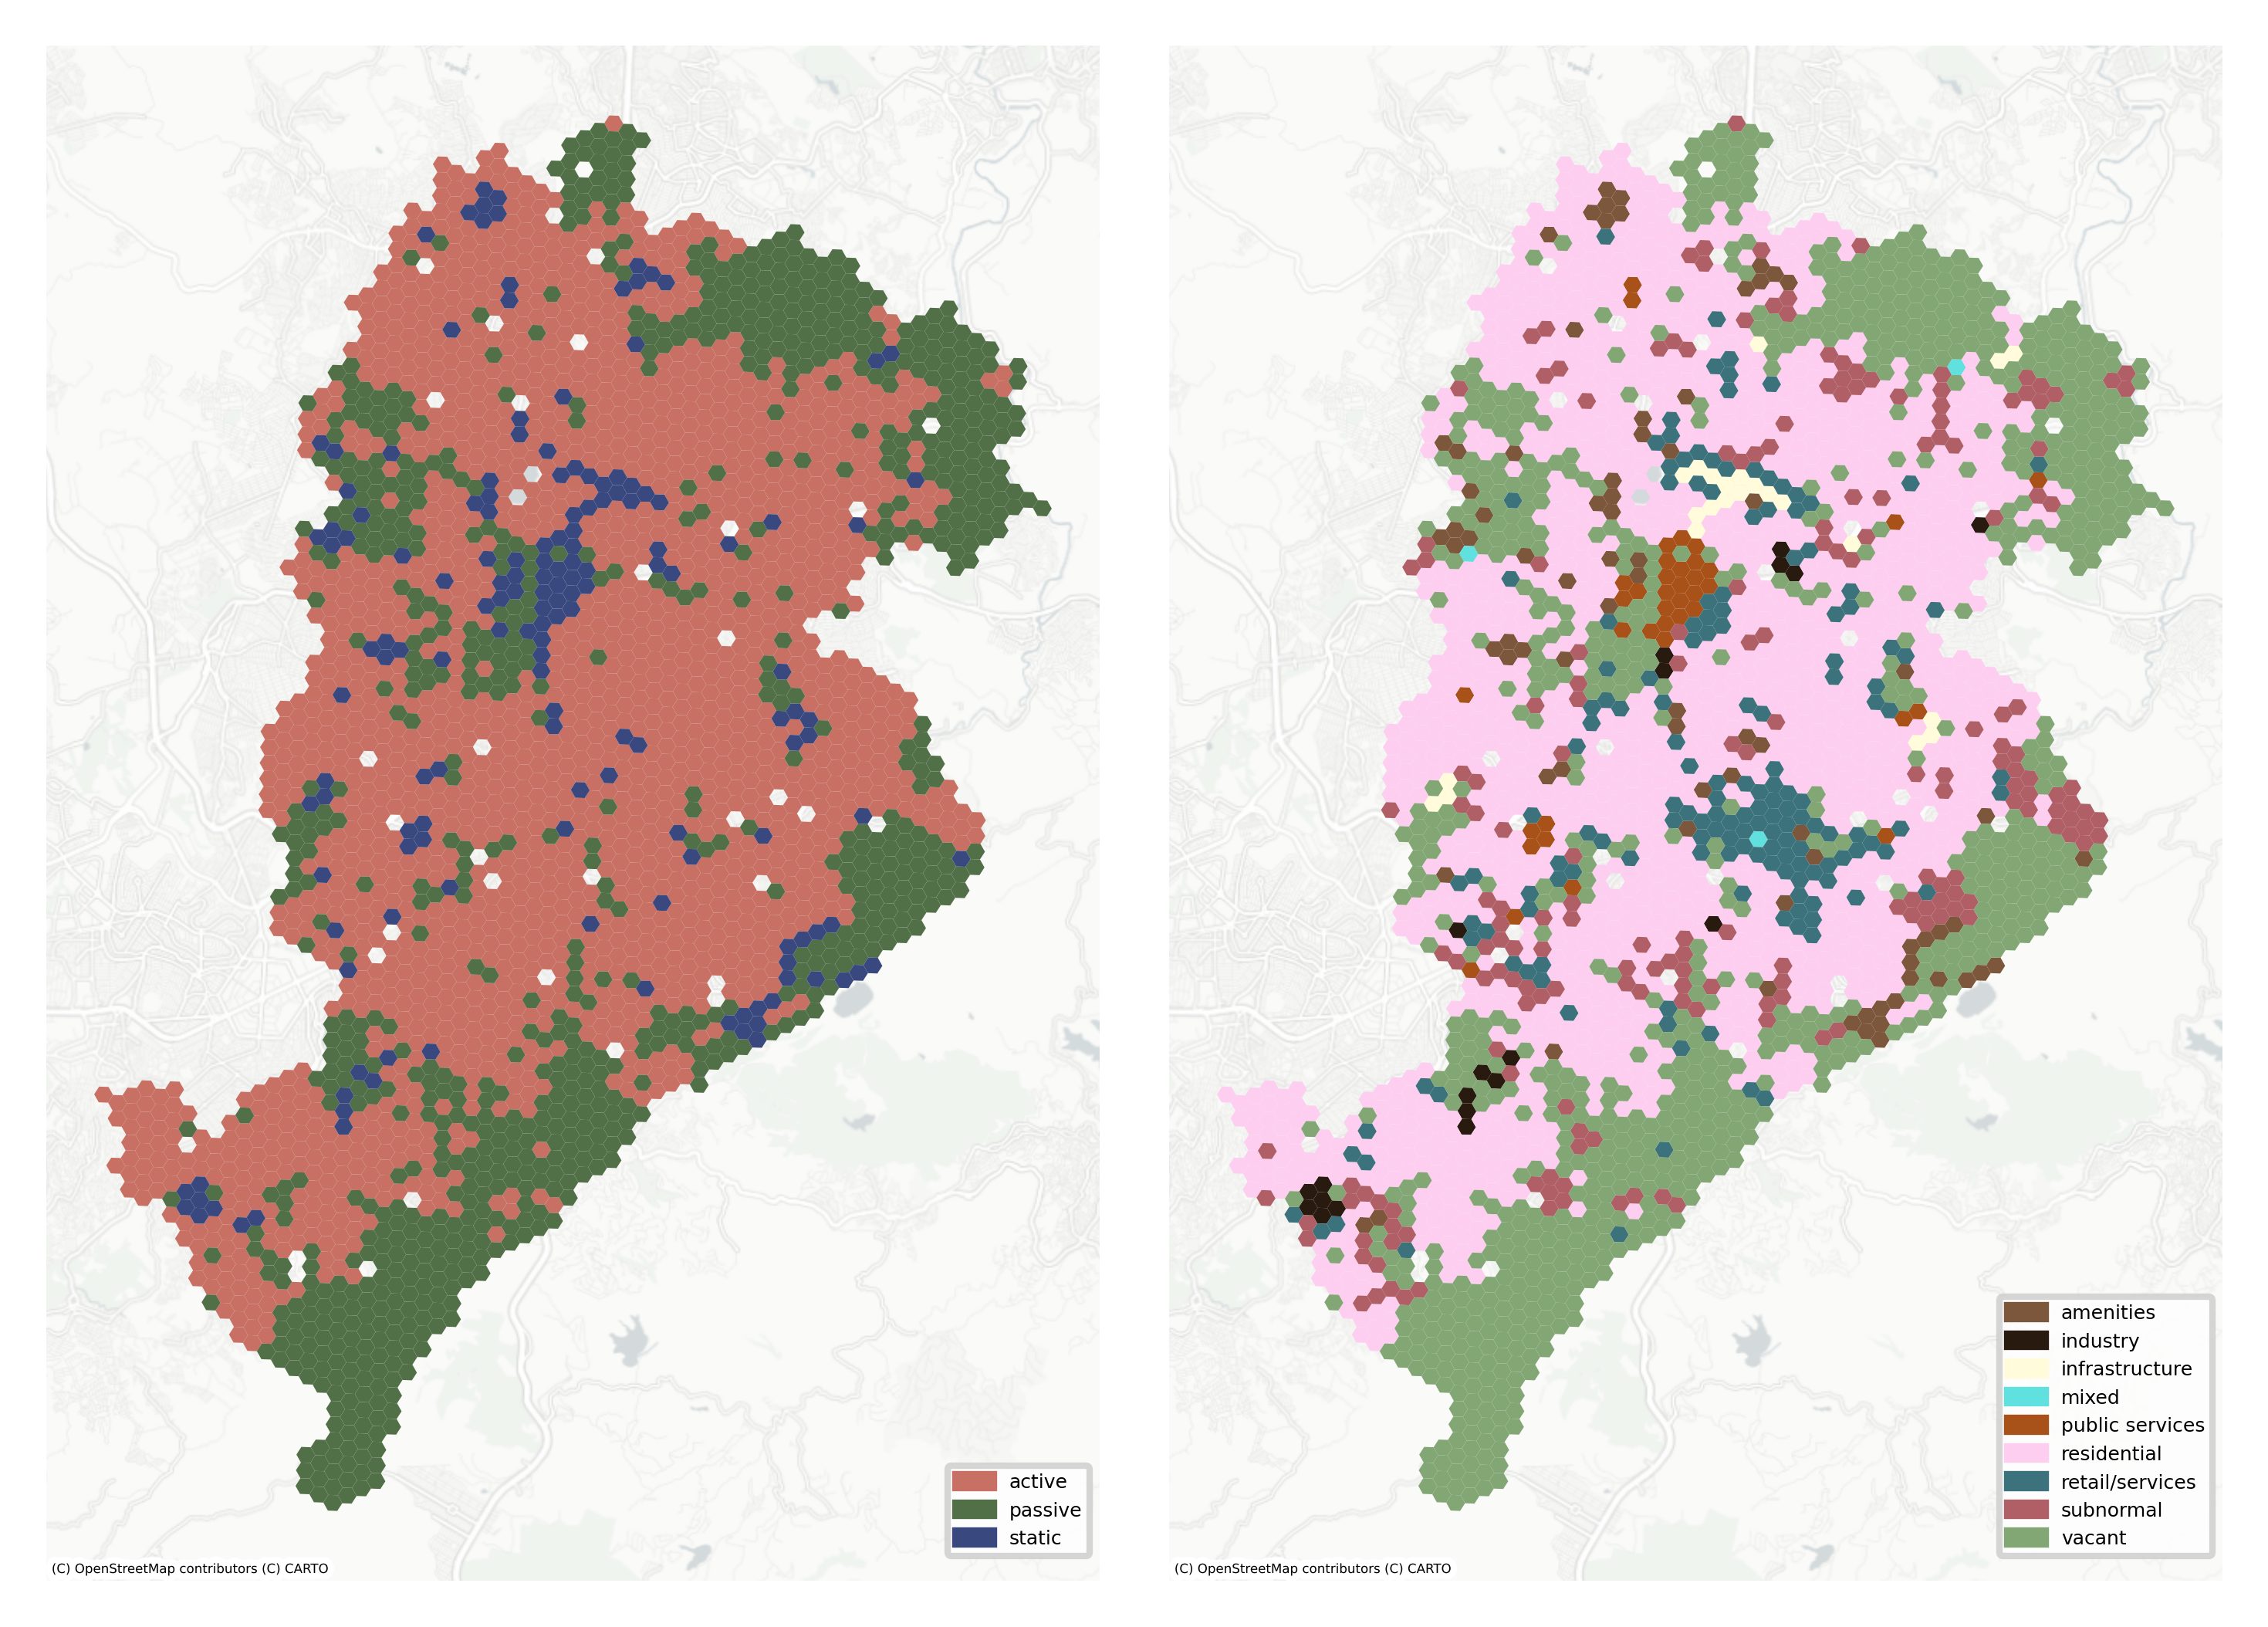

In [52]:
plot_land_uses(hex_2011, 2011, category_palette, use_palette)

## Map for 2017

In [53]:
plot_land_uses(hex_2017, 2017, category_palette, use_palette)

## Map for 2020

In [54]:
plot_land_uses(hex_2020, 2020, category_palette, use_palette)